# github_readme_nlp

In [1]:
# Setup environment
import pandas as pd
from requests import get
from bs4 import BeautifulSoup
import os
import time
import pandas as pd
import numpy as np
import unicodedata
import re
import json
import os
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import model
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 10))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import warnings
warnings.filterwarnings('ignore')

import prepare

## Acquire

We acquired all of our READMEs from github.com. We used an API-based script provided by Zach Gulde, but wrote our own methods using the Python requests library to get the list of repositories from which to pull.

Initially, we'd planned to pull the READMEs 100 most-starred repositories of four popular languages on GitHub: Python, JavaScript, PHP, and Shell. These were selected because they appeared to be fairly different from one another, and each was quite popular.

After our first run-through, we noticed some problems with the data. Somehow, we'd gotten some duplicate repositories in there, so we wrote code to ensure only unique repositories would count toward that 100.

We anticipated that we'd likely drop some of these repositories, since some of them appeared to be written in languages other than English, which would not be parsed by our NLP functions. Thus, we wound up grabbing 120 repositories per language, to later be reduced to 100.

## Prepare

Our prepare script takes the original, raw README text and translates it into something more easily understood by NLP algorithms. It also drops READMEs that are incomplete, missing or in a different language. It ultimately produces a dataframe with the original text, cleaned text, stemmed text, lemmatized text and the length in number of characters. If passed the 'model' flag it will also include word count and number of unique words.

We considered a few READMEs with massive word counts and many with very low word counts to be outliers. Those with very low word counts could not be considered for various reasons. Some were in Chinese initially and thus only contained the few anglicized words initially in the README. Others were the wrong README when there were multiple READMEs on a repo page. There were also some that simply said 'removed,' and some that were not READMEs, but symbolic links to the actual README elsewhere in the repository.

In [2]:
df = prepare.prep()

### Prep Summary

- Create data frame with cleaned data and language listed for exploratory analysis.

In [3]:
lemmas_df = df[['language', 'title', 'lemmatized']]

## Explore & Define Features

### Category Distribution

In [4]:
lemmas_df.dropna(inplace=True)

In [5]:
lemmas_df.shape

(480, 3)

In [6]:
lemmas_df.language.value_counts(normalize = True)

JavaScript    0.25
Python        0.25
PHP           0.25
Shell         0.25
Name: language, dtype: float64

,n,percent
JavaScript,120,0.25
Python,120,0.25
PHP,120,0.25
Shell,120,0.25


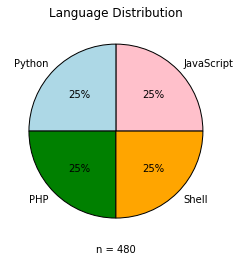

In [7]:
df.language.value_counts().plot.pie(
    colors = ['pink', 'lightblue', 'green', 'orange'], autopct = '%.0f%%')
plt.title("Language Distribution")
plt.ylabel("")
plt.xlabel('n = %d' % df.shape[0])

pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize = True)], axis = 1).set_axis(["n", "percent"], axis = 1, inplace = False)

**Note:** join all Readme and find high count of all words

In [8]:
pd.Series(" ".join(lemmas_df.lemmatized).split()).value_counts().head(10)

react     6320
native    5940
io        3864
source    3794
img       3562
use       3229
open      2810
href      2745
src       2695
master    2676
dtype: int64

**Note:** words within each language

In [9]:
all_words = ' '.join(lemmas_df.lemmatized).split()

python_words = ' '.join(lemmas_df[lemmas_df.language == 'Python'].lemmatized).split()

javascript_words = ' '.join(lemmas_df[lemmas_df.language == 'JavaScript'].lemmatized).split()

php_words = ' '.join(lemmas_df[lemmas_df.language == 'PHP'].lemmatized).split()

shell_words = ' '.join(lemmas_df[lemmas_df.language == 'Shell'].lemmatized).split()

- Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [10]:
all_freq = pd.Series(all_words).value_counts()

python_words_freq = pd.Series(python_words).value_counts()

javascript_words_freq = pd.Series(javascript_words).value_counts()

php_words_freq = pd.Series(php_words).value_counts()

shell_words_freq = pd.Series(shell_words).value_counts()

### Term Frequency

- Raw Count: This is simply the count of the number of occurances of each word.

In [11]:
raw_count = (
    pd.concat([all_freq, python_words_freq, javascript_words_freq, php_words_freq, shell_words_freq], axis=1, sort=True)
    .rename(columns={0: "All", 1: "Python", 2: "JavaScript", 3: "PHP", 4: "Shell"})
    .fillna(0)
    .apply(lambda col: col.astype(int))
)

In [12]:
raw_count.T

,aa,aaa,aaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaac,aaaaaaaaaai,aaaaaaaad,aaaaaaaaecm,...,zythum,zyusth,zyzsdy,zz,zzan,zzh,zzxadi,zzxcodeformat,zzz,zzzm
All,32,5,2,1,2,1,1,1,1,1,...,1,1,2,6,1,2,2,2,2,2
Python,10,0,0,1,2,1,0,0,0,0,...,0,0,2,0,0,2,0,2,0,2
JavaScript,16,1,0,0,0,0,1,1,1,1,...,1,1,0,4,0,0,0,0,0,0
PHP,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
Shell,0,4,2,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,2,0


**Note** return to the prepare phase to handle any special characters labels in the raw count.

In [13]:
raw_count.sort_values(by="All").tail(10)

,All,Python,JavaScript,PHP,Shell
master,2676,1207,691,350,428
src,2695,333,1861,285,216
href,2745,264,1753,246,482
open,2810,1819,693,80,218
use,3229,777,886,510,1056
img,3562,582,2175,402,403
source,3794,1945,1404,103,342
io,3864,895,2097,401,471
native,5940,32,5863,11,34
react,6320,13,6266,35,6


- Most common words overall?
- Most common Python, JavaScript, PHP, Shell words?
- Any words that uniquely Python, JavaScript, PHP, Shell words?

Text(0.5, 1.0, '10 most common words')

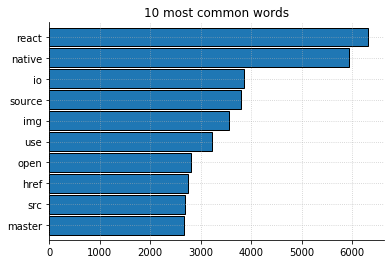

In [14]:
raw_count.sort_values(by='All')['All'].tail(10).plot.barh(width=.9)
plt.title('10 most common words')

Text(0.5, 1.0, '10 most common Python words')

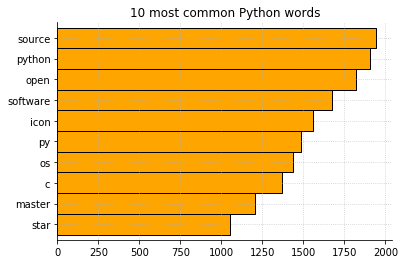

In [15]:
raw_count.sort_values(by='Python').Python.tail(10).plot.barh(width=1, color='Orange')
plt.title('10 most common Python words')

Text(0.5, 1.0, 'What are the most common JavaScript words')

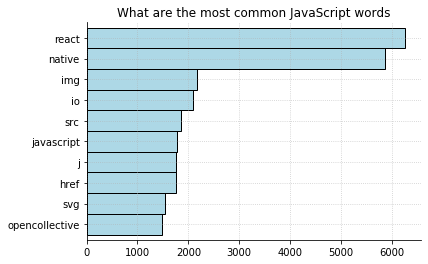

In [16]:
raw_count.sort_values(by='JavaScript').JavaScript.tail(10).plot.barh(width=1, color='lightblue')
plt.title('What are the most common JavaScript words')

Text(0.5, 1.0, 'What are the most common PHP words')

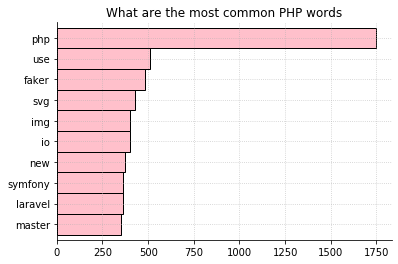

In [17]:
raw_count.sort_values(by='PHP').PHP.tail(10).plot.barh(width=1, color='pink')
plt.title('What are the most common PHP words')

Text(0.5, 1.0, 'What are the most common Shell words')

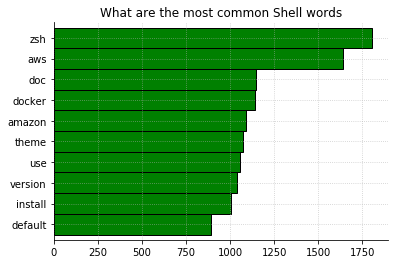

In [18]:
raw_count.sort_values(by='Shell').Shell.tail(10).plot.barh(width=1, color='green')
plt.title('What are the most common Shell words')

**Task**: create a data frame that contains the word its raw count, frequency, and augmented frequency. The augmented frequency is a normalization on the most frequency word.

In [19]:
tf_df = raw_count[['All']];
tf_df = tf_df.rename(columns={'All': 'raw_count'})
tf_df = tf_df.assign(frequency = lambda lemmas_df: lemmas_df.raw_count / lemmas_df.raw_count.sum())
tf_df = tf_df.assign(augmented_frequency = lambda lemmas_df: lemmas_df.frequency / lemmas_df.frequency.max())
tf_df.frequency.max()

tf_df.sample()


,raw_count,frequency,augmented_frequency
enwiki,2,0.000003,0.000316


### Ngrams

- Bigrams and visualizations of most frequent for all, Python, JavaScript, PHP, and Shell languages.

Text(0.5, 1.0, 'Bigrams for All Words')

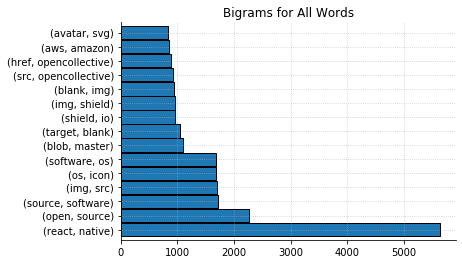

In [20]:
pd.Series(nltk.bigrams(all_words)).value_counts().head(15).plot.barh(width=.95).set_title('Bigrams for All Words')

Text(0.5, 1.0, 'Bigrams for Python Words')

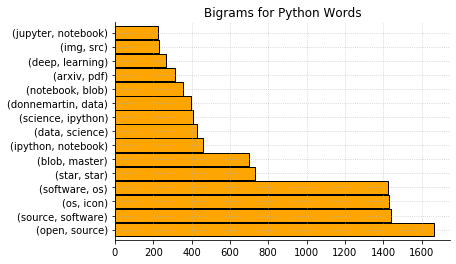

In [21]:
pd.Series(nltk.bigrams(python_words)).value_counts().head(15).plot.barh(width=.95, color='orange').set_title('Bigrams for Python Words')

Text(0.5, 1.0, 'Bigrams for JavaScript Words')

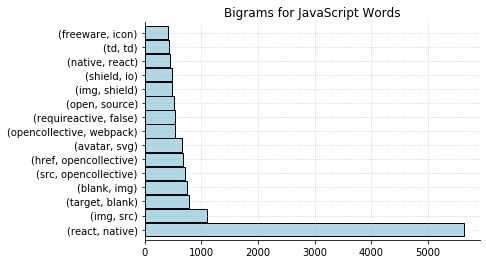

In [22]:
pd.Series(nltk.bigrams(javascript_words)).value_counts().head(15).plot.barh(width=.95, color='lightblue').set_title('Bigrams for JavaScript Words')

Text(0.5, 1.0, 'Bigrams for PHP Words')

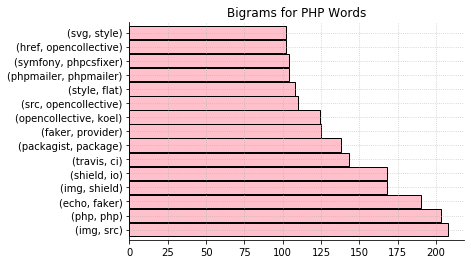

In [23]:
pd.Series(nltk.bigrams(php_words)).value_counts().head(15).plot.barh(width=.95, color='pink').set_title('Bigrams for PHP Words')

Text(0.5, 1.0, 'Bigrams for Shell Words')

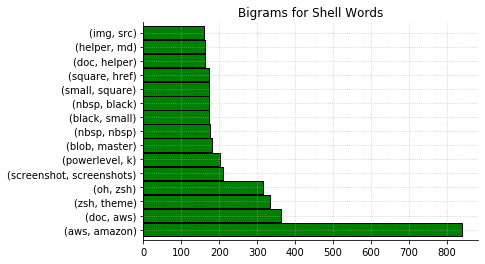

In [24]:
pd.Series(nltk.bigrams(shell_words)).value_counts().head(15).plot.barh(width=.95, color='green').set_title('Bigrams for Shell Words')

- Trigrams and visualizations of most frequent for all, Python, JavaScript, PHP, and Shell languages.

Text(0.5, 1.0, 'Trigrams for All Words')

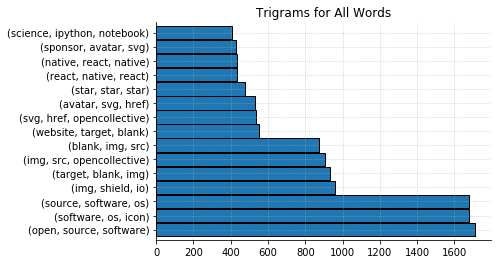

In [25]:
pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for All Words')

Text(0.5, 1.0, 'Trigrams for Python Words')

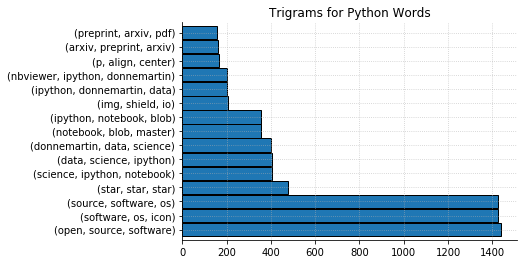

In [26]:
pd.Series(nltk.ngrams(python_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for Python Words')

Text(0.5, 1.0, 'Trigrams for JavaScript Words')

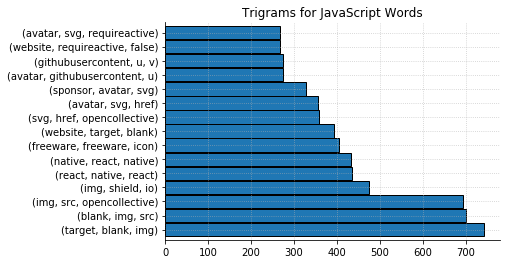

In [27]:
pd.Series(nltk.ngrams(javascript_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for JavaScript Words')

Text(0.5, 1.0, 'Trigrams for PHP Words')

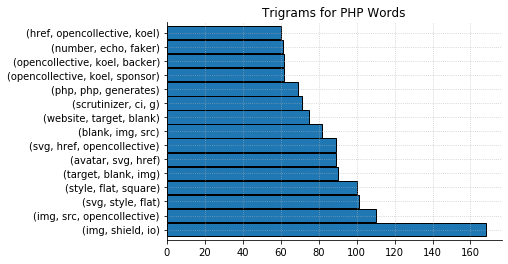

In [28]:
pd.Series(nltk.ngrams(php_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for PHP Words')

Text(0.5, 1.0, 'Trigrams for Shell Words')

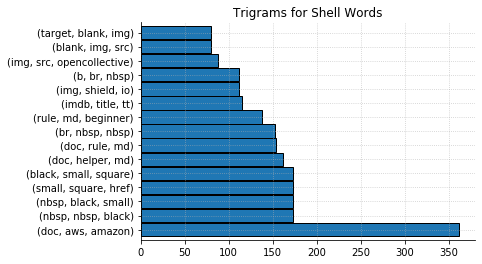

In [29]:
pd.Series(nltk.ngrams(shell_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for Shell Words')

### Document Length

In [30]:
lemmas_df["length"] = lemmas_df.lemmatized.apply(len)
lemmas_df.drop(index = lemmas_df[lemmas_df.length > 140000].index, inplace = True)

Text(0.5, 1.0, 'Document Length')

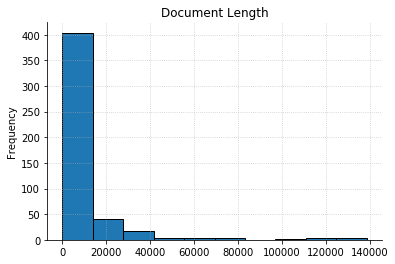

In [31]:
lemmas_df.length.plot.hist().set_title('Document Length')

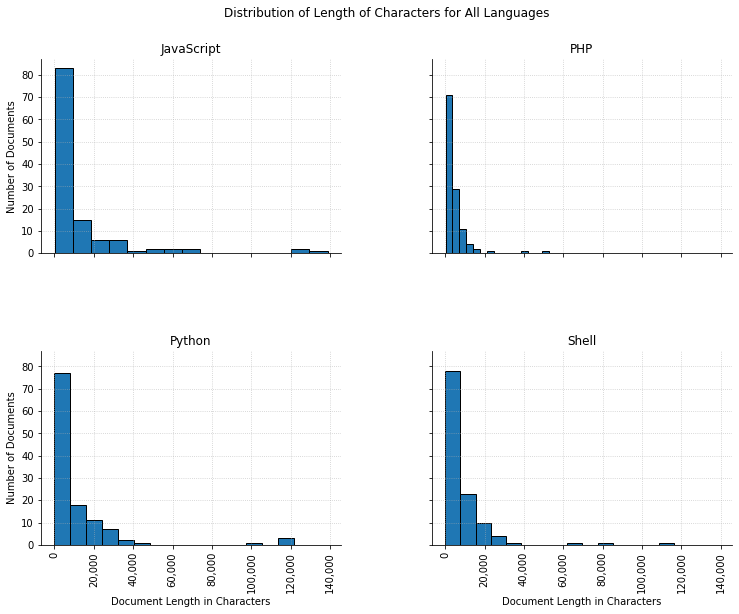

In [32]:
ar = lemmas_df.hist("length", by="language", sharex=True, sharey = True, layout=(2, 2), bins=15, figsize=(12, 9))
plt.suptitle('Distribution of Length of Characters for All Languages')

for ax in ar.flatten():
    ax.set_xlabel('Document Length in Characters')
    ax.set_ylabel('Number of Documents')
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

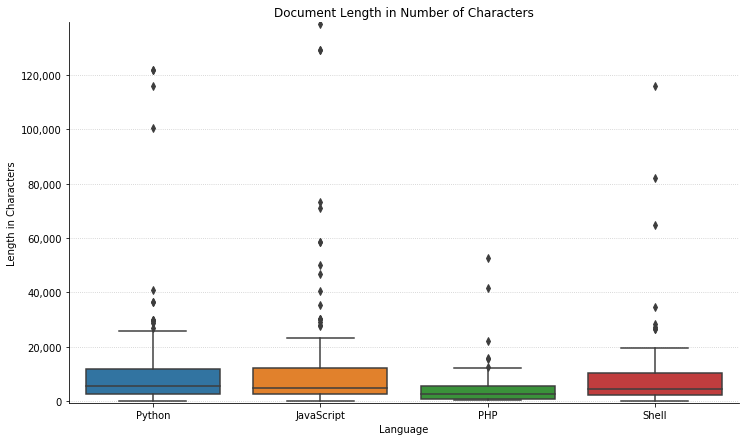

In [33]:
fig = plt.figure(figsize=(12, 7))

ax = sns.boxplot(data=lemmas_df, y="length", x="language")
ax.set_title('Document Length in Number of Characters')
ax.set_ylabel('Length in Characters')
ax.margins(.005) 
ax.set_xlabel('Language')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

### Number of Words

In [34]:
lemmas_df["n_words"] = lemmas_df.lemmatized.str.count(r"\w+")

In [35]:
lemmas_df.groupby("language").n_words.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
JavaScript,120.0,1957.700000,3386.842918,5.0,369.00,728.0,1793.50,19654.0
PHP,120.0,614.566667,946.124050,23.0,124.25,349.5,774.25,7202.0
Python,120.0,1733.683333,3023.482187,2.0,335.50,884.5,1771.00,17444.0
Shell,119.0,1337.277311,2190.729338,1.0,335.50,669.0,1495.50,16737.0


Text(0.5, 1.0, 'Document Length in Number of Words')

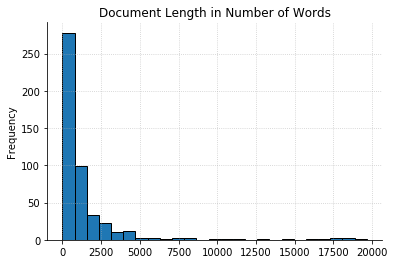

In [36]:
lemmas_df.n_words.plot.hist(bins = 25).set_title('Document Length in Number of Words')



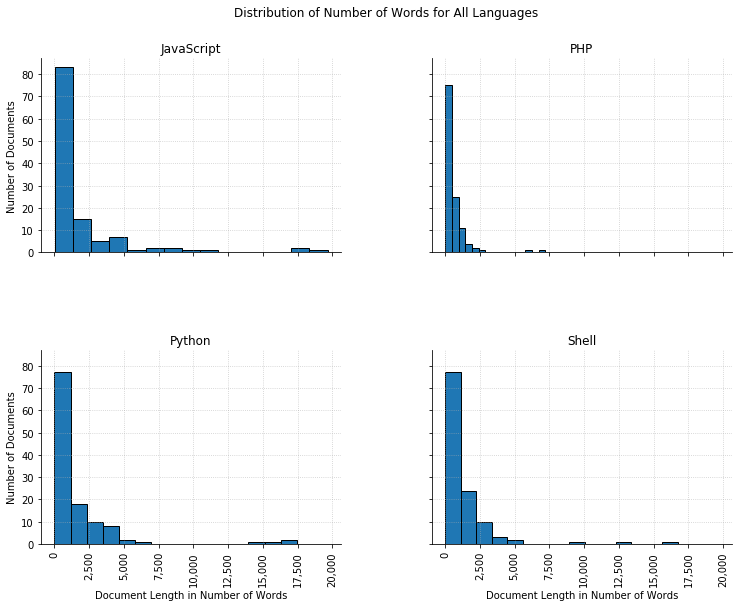

In [37]:
ar = lemmas_df.hist("n_words", by="language", sharex=True, sharey = True, layout=(2, 2), bins=15, figsize=(12, 9))
plt.suptitle("Distribution of Number of Words for All Languages")

for ax in ar.flatten():
    ax.set_xlabel('Document Length in Number of Words')
    ax.set_ylabel('Number of Documents')
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

### Word Cloud

- WordCloud with all words

(-0.5, 1499.5, 999.5, -0.5)

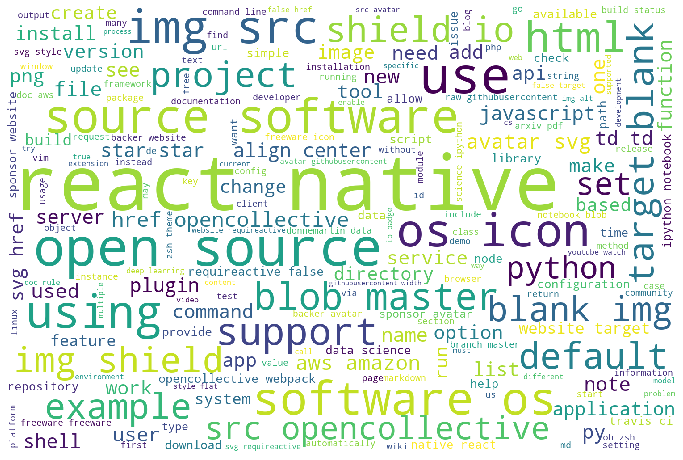

In [38]:
corpus = ' '.join(all_words)

plt.figure(figsize=(12,12))
img = WordCloud(background_color="white", height=1000, width=1500, random_state=123).generate(corpus)
plt.imshow(img)
plt.axis("off")

- WordCloud with all words by languages

In [39]:
python_corpus = ' '.join(python_words)
javascript_corpus = ' '.join(javascript_words)
php_corpus = ' '.join(php_words)
shell_corpus = ' '.join(shell_words)

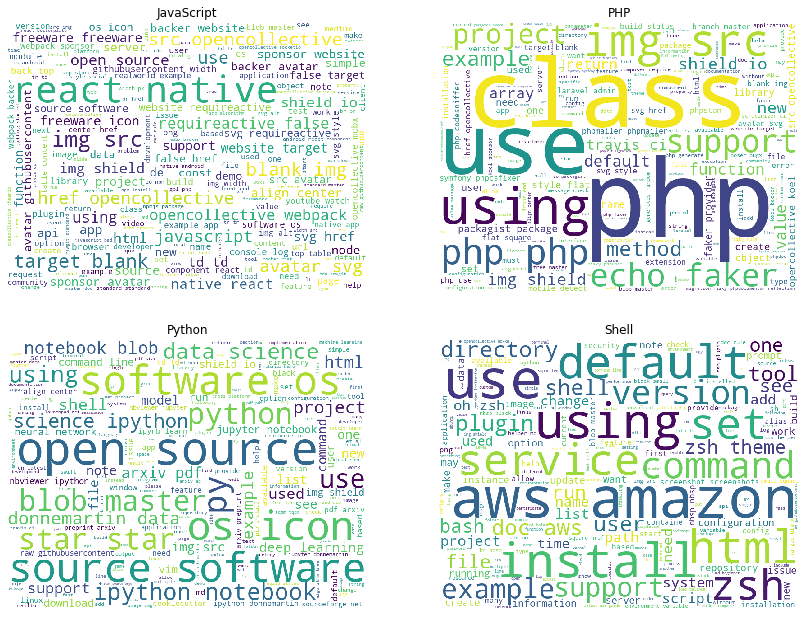

In [40]:
python_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(python_words)
)
javascript_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(javascript_words)
)
php_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(php_words)
)
shell_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(shell_words)
)

plt.figure(figsize=(10, 8))
axs = [
    plt.axes([0, 0, 0.5, 0.5]),
    plt.axes([0, 0.55, 0.5, .5]),
    plt.axes([0.6, 0.55, 0.5, 0.5]),
    plt.axes([0.6, 0, 0.5, 0.5]),
]

axs[0].imshow(python_cloud)
axs[1].imshow(javascript_cloud)
axs[2].imshow(php_cloud)
axs[3].imshow(shell_cloud)

axs[0].set_title("Python")
axs[1].set_title("JavaScript")
axs[2].set_title("PHP")
axs[3].set_title("Shell")

for ax in axs:
    ax.axis("off")    

### Word Cloud with Bigrams

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with All Words')

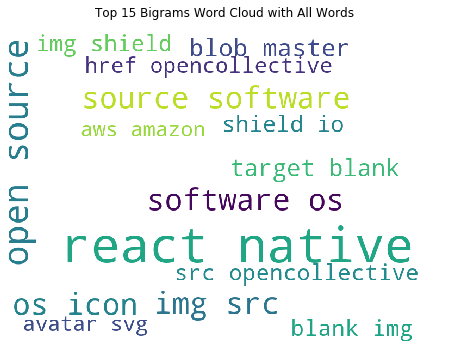

In [41]:
all_bigrams = pd.Series(nltk.bigrams(all_words)).value_counts().head(15)

all_data = {p1 + " " + p2: v for (p1, p2), v in all_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(all_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with All Words')

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with Python Words')

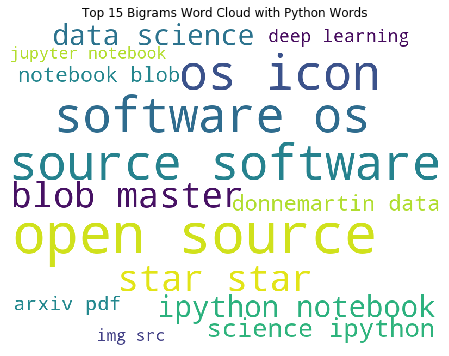

In [42]:
python_bigrams = pd.Series(nltk.bigrams(python_words)).value_counts().head(15)

python_data = {p1 + " " + p2: v for (p1, p2), v in python_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(python_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with Python Words')

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with JavaScript Words')

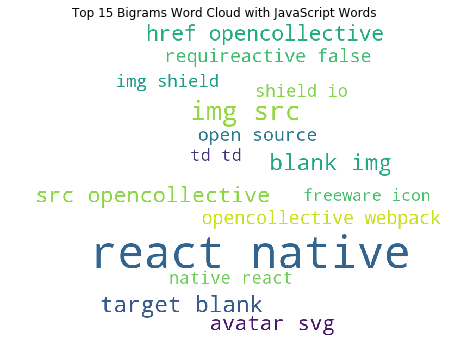

In [43]:
javascript_bigrams = pd.Series(nltk.bigrams(javascript_words)).value_counts().head(15)

javascript_data = {p1 + " " + p2: v for (p1, p2), v in javascript_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(javascript_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with JavaScript Words')

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with PHP Words')

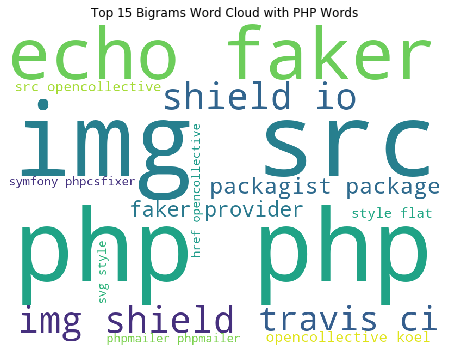

In [44]:
php_bigrams = pd.Series(nltk.bigrams(php_words)).value_counts().head(15)

php_data = {p1 + " " + p2: v for (p1, p2), v in php_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(php_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with PHP Words')

Text(0.5, 1.0, 'Top 15 Bigrams Word Cloud with Shell Words')

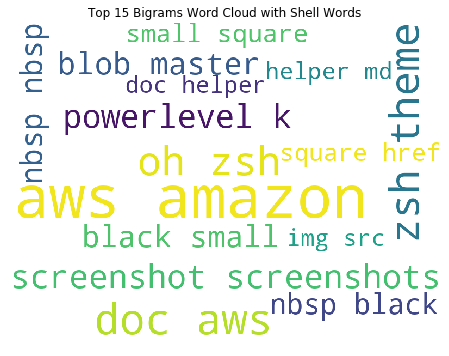

In [45]:
shell_bigrams = pd.Series(nltk.bigrams(shell_words)).value_counts().head(15)

shell_data = {p1 + " " + p2: v for (p1, p2), v in shell_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(shell_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Bigrams Word Cloud with Shell Words')

### Word Cloud with Trigrams

Text(0.5, 1.0, 'Top 15 Trigrams with All Words')

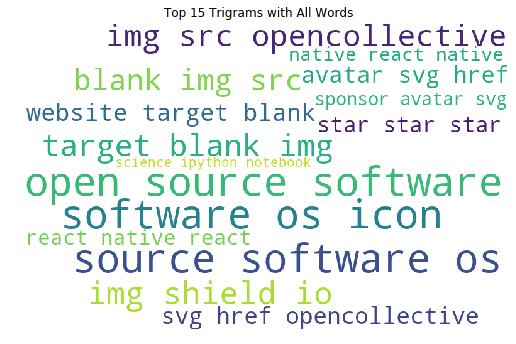

In [46]:
all_trigrams = pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in all_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with All Words')

Text(0.5, 1.0, 'Top 15 Trigrams with Python Words')

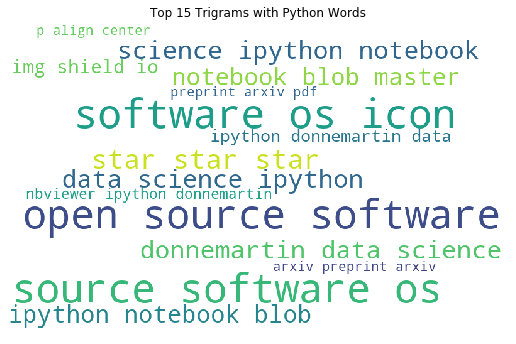

In [47]:
python_trigrams = pd.Series(nltk.ngrams(python_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in python_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with Python Words')

Text(0.5, 1.0, 'Top 15 Trigrams with JavaScript Words')

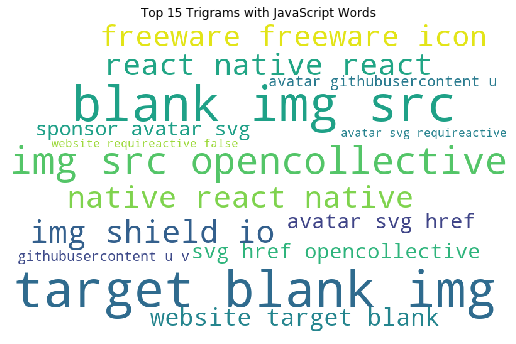

In [48]:
javascript_trigrams = pd.Series(nltk.ngrams(javascript_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in javascript_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with JavaScript Words')

Text(0.5, 1.0, 'Top 15 Trigrams with PHP Words')

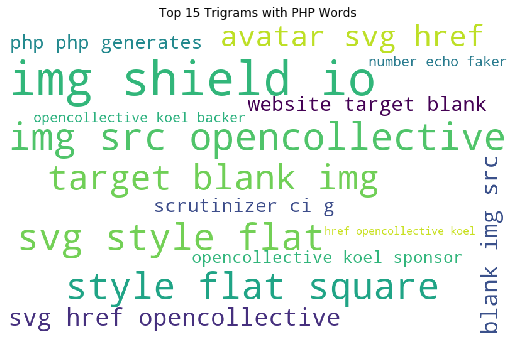

In [49]:
php_trigrams = pd.Series(nltk.ngrams(php_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in php_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with PHP Words')

Text(0.5, 1.0, 'Top 15 Trigrams with Shell Words')

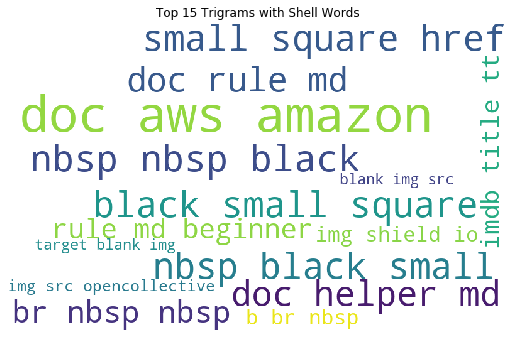

In [50]:
shell_trigrams = pd.Series(nltk.ngrams(shell_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in shell_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Top 15 Trigrams with Shell Words')

### Modeling

First we created a dataframe that includes word count and unique words columns. This was necessary to compute Term Frequency - Inverse Document Frequency for our models.

In [51]:
df = prepare.prep(model=True)

The below function, prevent_overfitting( ), creates the model specified in the first argument using the dataframe provided in the second. It then splits the data into x_train, x_test, y_train, and y_test. A 20% portion for testing was chosen. The x-values are the Term Frequency - Inverse Document Frequency of each word in our corpus, by document. The y-value is what programming language of each document.

It initializes the model with min_samples_leaf = 1, and iterates upward until the difference between the train accuracy and test accuracy is less than .06. Finally, it prints the ultimate min_samples_leaf value, accuracy in train data set, and accuracy in test data set.

In [52]:
dt = model.prevent_overfitting(DecisionTreeClassifier, df)

leaf = 9
train acc = 0.8531734934503739
test acc = 0.8022195640616693


**Note:** A Random Forest model was also used, but it performed significantly worse.

In [53]:
rf = model.prevent_overfitting(RandomForestClassifier, df)

leaf = 14
train acc = 0.7855681818181819
test acc = 0.7363095238095239


When running our evaluation metrics, they often change due to some randomness in the modeling. The below scores reflect the highest we've seen, which is the model we stored to predict future READMEs.

In [54]:
dt = model.get_model()

### Final Analysis

- Attempt more modeling using different models (Logistic Regression, SGD Classifier, Support-Vector Classifier).


- Further analysis for including stop words to enhance performance.


- Expand the acquisition of data to include additional programming languages as well as increase the quantity of data.


- Include the acquired symbolically linked READMEs rather than remove them.